Xtrain shape: (1624, 2), ytrain shape: (1624,)
Grid shape: X=(319, 243), Y=(319, 243), land_mask=(77517,)


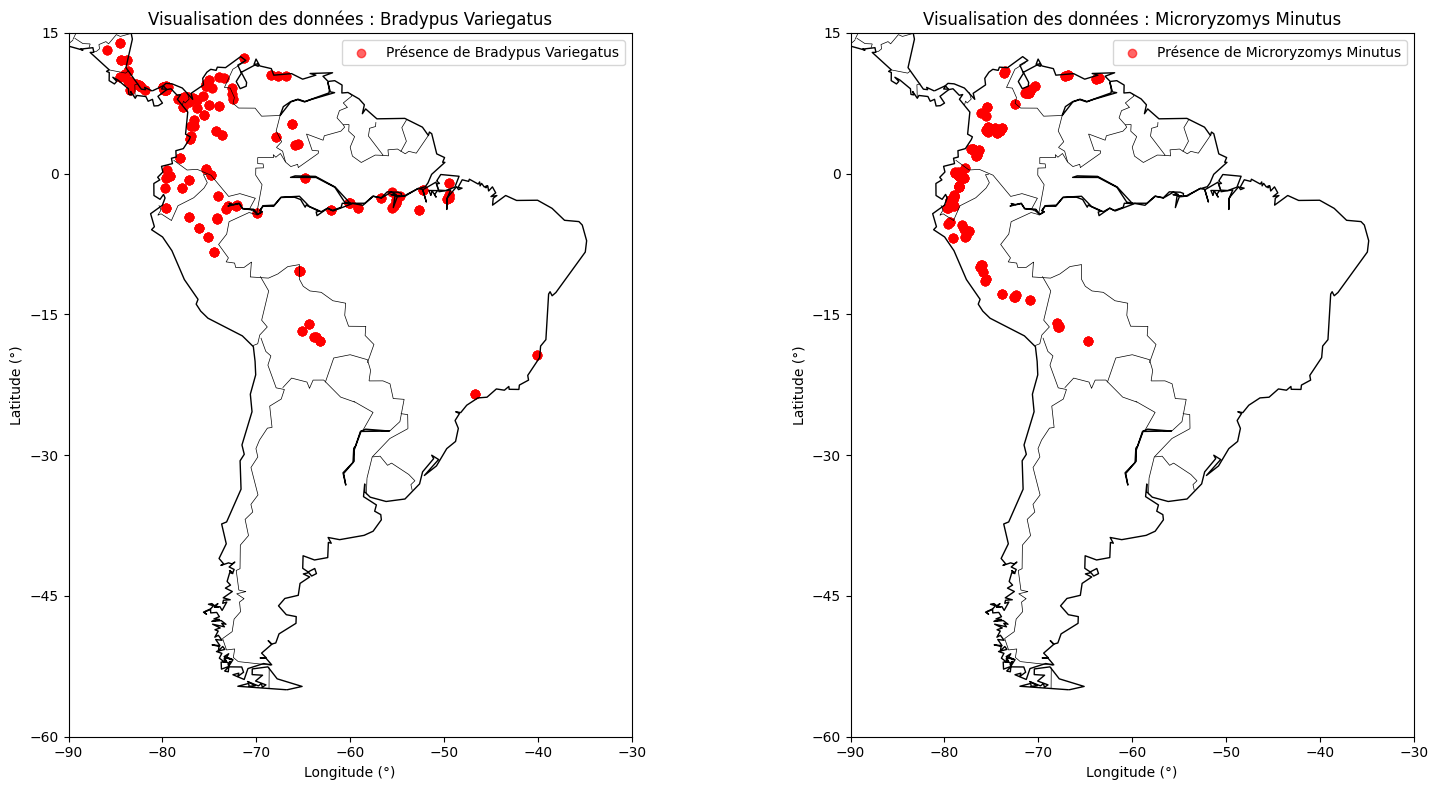

 - computing KDE for Bradypus Variegatus
Z shape before reshape: (77517,)
Z shape after reshape: (319, 243)
 - computing KDE for Microryzomys Minutus
Z shape before reshape: (77517,)
Z shape after reshape: (319, 243)
 - plotting distributions


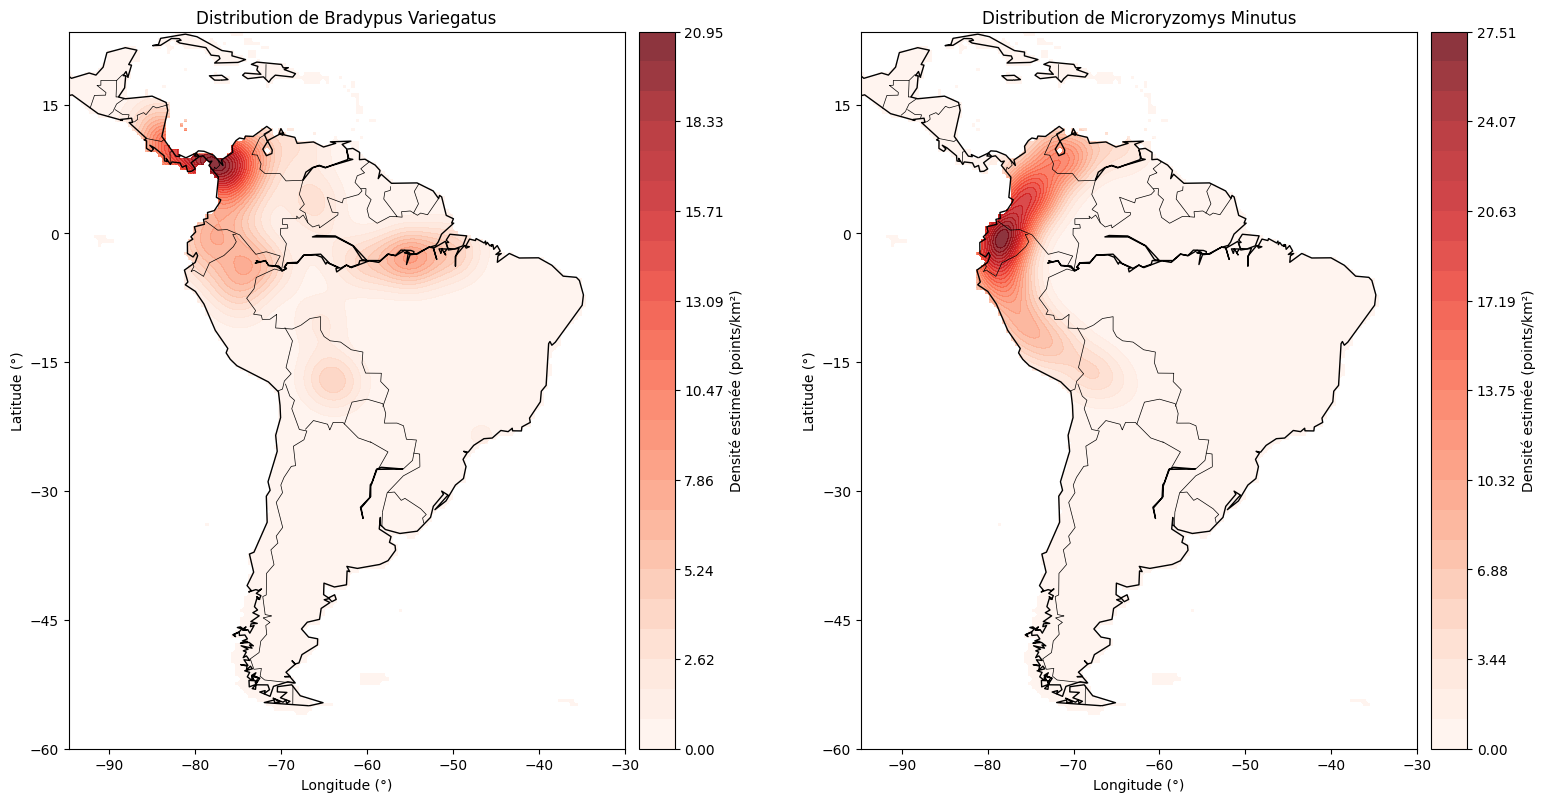

In [7]:
# Ce script Python effectue une estimation de densité à noyau (KDE) sur des données
# de distribution d'espèces fournies par scikit-learn. Il tente ensuite de visualiser
# ces distributions sur une carte si les bibliothèques matplotlib et Basemap sont
# disponibles. Si matplotlib n'est pas installé, la partie de la visualisation est
# ignorée et un message est affiché à l'utilisateur.

import numpy as np
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets._species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

# Bloc try-except pour importer matplotlib et Basemap (qui est optionnel).
# Si une ImportError se produit (signifiant que la bibliothèque n'est pas installée),
# les variables basemap et plotting_available sont mises à False.
try:
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    basemap = True
    plotting_available = True
except ImportError:
    basemap = False
    plotting_available = False

def load_data():
    """
    Charge les données de distribution des espèces à l'aide de la fonction
    fetch_species_distributions de scikit-learn.

    Returns:
        tuple: Un tuple contenant les données chargées et une liste des noms
               des deux espèces étudiées ('Bradypus Variegatus' et
               'Microryzomys Minutus').
    """
    data = fetch_species_distributions()
    species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
    return data, species_names

def prepare_training_data(data):
    """
    Prépare les données d'entraînement pour le modèle KDE. Extrait les latitudes
    et longitudes des données d'entraînement et crée un tableau NumPy où chaque
    ligne représente un point (latitude, longitude). Convertit également les
    coordonnées de degrés en radians, ce qui est nécessaire pour la métrique
    'haversine' utilisée dans KernelDensity. Crée également un tableau d'étiquettes
    indiquant l'espèce pour chaque point d'entraînement.

    Args:
        data (Bunch): Les données chargées par fetch_species_distributions.

    Returns:
        tuple: Un tuple contenant :
            - Xtrain (ndarray): Un tableau 2D des coordonnées d'entraînement
              (latitude, longitude) en radians.
            - ytrain (ndarray): Un tableau 1D d'entiers indiquant l'espèce
              correspondante pour chaque point dans Xtrain (0 pour la première
              espèce, 1 pour la seconde).
    """
    Xtrain = np.vstack([data['train']['dd lat'], data['train']['dd long']]).T
    ytrain = np.array([d.decode('ascii').startswith('micro')
                      for d in data['train']['species']], dtype='int')
    Xtrain *= np.pi / 180.  # Conversion des degrés en radians
    return Xtrain, ytrain

def prepare_grid(data):
    """
    Construit la grille de points sur laquelle la densité sera évaluée. Utilise
    la fonction construct_grids de scikit-learn pour créer les grilles de
    latitude et de longitude. Crée ensuite un maillage (meshgrid) à partir de
    ces grilles et applique un masque pour ne conserver que les points situés
    sur terre (en utilisant les données de couverture terrestre). Convertit
    également les coordonnées de la grille en radians.

    Args:
        data (Bunch): Les données chargées par fetch_species_distributions.

    Returns:
        tuple: Un tuple contenant :
            - X (ndarray): Un tableau 2D des longitudes de la grille.
            - Y (ndarray): Un tableau 2D des latitudes de la grille.
            - land_reference (ndarray): Une sous-section de la couverture terrestre
              utilisée comme référence.
            - land_mask (ndarray): Un masque booléen 1D indiquant les points de la
              grille situés sur terre.
            - xy (ndarray): Un tableau 2D des coordonnées (latitude, longitude)
              des points de la grille situés sur terre, en radians.
    """
    xgrid, ygrid = construct_grids(data)
    X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])  # Sous-échantillonnage de la grille
    land_reference = data.coverages[6][::5, ::5]
    land_mask = (land_reference > -9999).ravel()  # Masque pour les zones terrestres

    xy = np.vstack([Y.ravel(), X.ravel()]).T
    xy = xy[land_mask]
    xy *= np.pi / 180.  # Conversion des degrés en radians

    return X, Y, land_reference, land_mask, xy

def compute_kde(Xtrain, ytrain, species_index, bandwidth=0.04):
    """
    Calcule l'estimation de densité à noyau (KDE) pour une espèce spécifique.
    Utilise un noyau gaussien et la métrique de la distance haversine (adaptée
    aux données sphériques comme les coordonnées géographiques). Le modèle KDE
    est ajusté uniquement sur les points d'entraînement correspondant à l'espèce
    indiquée par species_index.

    Args:
        Xtrain (ndarray): Les données d'entraînement (latitude, longitude) en radians.
        ytrain (ndarray): Les étiquettes des espèces pour les données d'entraînement.
        species_index (int): L'indice de l'espèce pour laquelle calculer le KDE (0 ou 1).
        bandwidth (float, optional): La largeur de bande du noyau gaussien.
            Contrôle le lissage de l'estimation de densité. Defaults to 0.04.

    Returns:
        KernelDensity: Un objet KernelDensity ajusté aux données de l'espèce spécifiée.
    """
    kde = KernelDensity(bandwidth=bandwidth, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == species_index])
    return kde


def plot_species_distribution(X, Y, Z_list, land_reference, species_names):
    """
    Trace les distributions de densité estimées pour chaque espèce sur une seule
    figure, avec chaque distribution affichée sur un sous-graphique séparé.
    Utilise des contours remplis pour représenter la densité et ajoute une barre
    de couleur verticale pour indiquer les valeurs de densité. Si Basemap est
    disponible, une carte de base est ajoutée pour le contexte géographique.
    Sinon, les contours de la référence terrestre sont affichés.

    Args:
        X (ndarray): Les longitudes de la grille.
        Y (ndarray): Les latitudes de la grille.
        Z_list (list): Une liste de tableaux 2D représentant les densités estimées
                       pour chaque espèce.
        land_reference (ndarray): La référence de la couverture terrestre.
        species_names (list): Une liste des noms des espèces.
    """
    if not plotting_available:
        print("Skipping plot: matplotlib not available.")
        return

    # Ajuster la taille de la figure pour une meilleure lisibilité
    plt.figure(figsize=(16, 8))  # Taille augmentée pour afficher les deux cartes côte à côte

    for i, (Z, species_name) in enumerate(zip(Z_list, species_names)):
        plt.subplot(1, 2, i + 1)

        # Définir les niveaux pour les contours
        levels = np.linspace(0, Z.max(), 25)
        contour = plt.contourf(X, Y, Z, levels=levels, cmap='Reds', alpha=0.8)

        # Ajouter une carte de base si disponible
        if basemap:
            m = Basemap(projection='cyl', llcrnrlat=Y.min(), urcrnrlat=Y.max(),
                        llcrnrlon=X.min(), urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            plt.contour(X, Y, land_reference, levels=[-9999], colors="k", linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        # Ajouter une barre de couleur verticale pour les densités
        cbar = plt.colorbar(contour, orientation='vertical', pad=0.02)
        cbar.set_label('Densité estimée (points/km²)')

        # Ajouter des titres, des étiquettes d'axes et des graduations
        plt.title(f"Distribution de {species_name}")
        plt.xlabel("Longitude (°)")
        plt.ylabel("Latitude (°)")
        plt.xticks(np.arange(-90, -29, 10))  # Graduations pour la longitude
        plt.yticks(np.arange(-60, 16, 15))  # Graduations pour la latitude

    plt.tight_layout()
    plt.show()


def visualize_dataset(Xtrain, ytrain, species_names):
    """
    Visualise les points de données d'entraînement pour chaque espèce sur des
    sous-graphiques séparés. Chaque point est coloré en fonction de l'espèce.
    Si Basemap est disponible, une carte de base de l'Amérique du Sud est
    affichée en arrière-plan. Sinon, les limites de longitude et de latitude
    pour l'Amérique du Sud sont définies et une grille est ajoutée.

    Args:
        Xtrain (ndarray): Les données d'entraînement (latitude, longitude) en radians.
        ytrain (ndarray): Les étiquettes des espèces pour les données d'entraînement.
        species_names (list): Une liste des noms des espèces.
    """
    if not plotting_available:
        print("Skipping raw dataset visualization: matplotlib not available.")
        return

    # Ajuster la taille de la figure pour une meilleure lisibilité
    plt.figure(figsize=(16, 8))  # Taille augmentée pour améliorer la visibilité

    for i, species_name in enumerate(species_names):
        plt.subplot(1, 2, i + 1)

        # Scatter plot des points d'entraînement
        plt.scatter(Xtrain[ytrain == i, 1] * 180 / np.pi,  # longitude
                    Xtrain[ytrain == i, 0] * 180 / np.pi,  # latitude
                    label=f"Présence de {species_name}", alpha=0.6, c='red')

        # Ajouter une carte de base si disponible
        if basemap:
            m = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=15,  # Limites pour l'Amérique du Sud
                        llcrnrlon=-90, urcrnrlon=-30, resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            plt.xlim(-90, -30)  # Limites de longitude pour l'Amérique du Sud
            plt.ylim(-60, 15)   # Limites de latitude pour l'Amérique du Sud
            plt.grid(True, linestyle='--', alpha=0.5)

        # Ajouter des légendes, des titres et des graduations
        plt.title(f"Visualisation des données : {species_name}")
        plt.xlabel("Longitude (°)")
        plt.ylabel("Latitude (°)")
        plt.xticks(np.arange(-90, -29, 10))  # Graduations pour la longitude
        plt.yticks(np.arange(-60, 16, 15))  # Graduations pour la latitude
        plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


def main():
    """
    Fonction principale qui orchestre le chargement des données, la préparation
    des données d'entraînement et de la grille, le calcul des estimations de
    densité à noyau pour chaque espèce et la visualisation des résultats.
    """
    data, species_names = load_data()
    Xtrain, ytrain = prepare_training_data(data)
    X, Y, land_reference, land_mask, xy = prepare_grid(data)

    print(f"Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}")
    print(f"Grid shape: X={X.shape}, Y={Y.shape}, land_mask={land_mask.shape}")

    visualize_dataset(Xtrain, ytrain, species_names)

    if plotting_available:
        Z_list = []
        for i in range(2):
            print(f" - computing KDE for {species_names[i]}")
            kde = compute_kde(Xtrain, ytrain, species_index=i)

            # Préparer Z (les estimations de densité sur la grille terrestre)
            Z = -9999 + np.zeros(land_mask.shape[0])
            Z[land_mask] = np.exp(kde.score_samples(xy))
            print(f"Z shape before reshape: {Z.shape}")
            Z = Z.reshape(X.shape)  # Remodeler pour correspondre à la grille
            print(f"Z shape after reshape: {Z.shape}")

            Z_list.append(Z)

        print(" - plotting distributions")
        plot_species_distribution(X, Y, Z_list, land_reference, species_names)

if __name__ == "__main__":
    main()